In [1]:
import matplotlib.pyplot as plt

import numpy as np
import time
import itertools

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import sys

from normalizingflows.flow_catalog import PlanarFlow, Made
from data.visu_density import plot_heatmap_2d
from data.toy_data import generate_2d_data
from data.plot_samples import plot_samples_2d
from utils.train_utils import shuffle_split, sanity_check, train_density_estimation
from sklearn.model_selection import train_test_split

tfd = tfp.distributions
tfb = tfp.bijectors
#tf.random.set_seed(1234)

tensorflow:  2.0.0
tensorflow-probability:  0.8.0-rc0


In [2]:
def normal_grad(x, sd):
    # Normal grad, 2 dimensions
    x1 = x[:,0]
    x2 = x[:,1]

    fx1 = 1/(sd[0] * np.sqrt(2*np.pi)) * np.exp(-x1**2/(2*sd[0]**2))
    fx2 = 1/(sd[1] * np.sqrt(2*np.pi)) * np.exp(-x2**2/(2*sd[1]**2))
    
    grad = np.zeros((len(x), 2))
    
    grad1 = fx2 * 1/(sd[0] * np.sqrt(2*np.pi)) * np.exp(-x1**2/(2*sd[0]**2)) * (-x1/(sd[0]**2))
    grad2 = fx1 * 1/(sd[1] * np.sqrt(2*np.pi)) * np.exp(-x2**2/(2*sd[1]**2)) * (-x2/(sd[1]**2))
    
    grad[:,0] = grad1
    grad[:,1] = grad2
    return grad
    
def tweedies(data, dist, plot_grad=True, plot_density=True, plot_tweedies=True, min_val=-0.5, max_val=0.5):
    # Tweedies formula
    covariance = np.cov(data.numpy().T)
    with tf.GradientTape() as tape:
        tape.watch(data)
        prob = dist.prob(data)
        gradients = tape.gradient(prob, data)
    
    gradients = gradients.numpy()
    prob = prob.numpy()
    prob_div = prob.reshape((len(gradients), 1))
    tweedies = data.numpy() + np.clip((covariance @ (gradients / prob_div).T).T, min_val, max_val) #Clip quotient for stability
    # Plot flags
    if plot_grad:
        sum_grads = np.sum(gradients, axis=1)
        plt.scatter(data[:,0], data[:,1], c=np.clip(sum_grads, min_val, max_val), s=7 , cmap='Spectral')
        plt.title('Gradients')
        cbar = plt.colorbar()
        plt.show()
    if plot_density:
        plt.scatter(data[:,0], data[:,1], c=prob, s=7 , cmap='Spectral')
        plt.title('Density')
        cbar = plt.colorbar()
        plt.show()
    if plot_tweedies:
        plt.scatter(data[:,0], data[:,1], c=sum(np.clip((gradients/prob_div).T, min_val, max_val)), s=7 , cmap='Spectral')
        plt.title('Quotient Term')
        cbar = plt.colorbar()
        plt.show()
        plt.scatter(data[:,0], data[:,1], c=sum(np.clip((covariance @ (gradients / prob_div).T), min_val, max_val)), s=7 , cmap='Spectral')
        plt.title('Tweedies Term')
        cbar = plt.colorbar()
        plt.show()
    return tweedies

def maf_flow(layers, hidden_shape, batched_train_data, val_data, early_stop=True, base_lr = 1e-3, end_lr = 1e-4,  max_epochs = 500, delta_stop=700, plot_freq=100, x_min=-3, x_max=3, n=50):
    # Masked Autoregressive Flow Implementation
    
    #For plotting
    grid = np.linspace(x_min, x_max, n)
    mesh = np.array(list(itertools.product(grid, grid)))
    mesh = tf.convert_to_tensor(mesh, dtype=np.float32)
    
    base_dist = tfd.Normal(loc=0.0, scale=1.0)  # specify base distribution

    bijectors = []
    for i in range(0, layers):
        bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn = Made(params=2, hidden_units=hidden_shape, activation="relu")))
        bijectors.append(tfb.Permute(permutation=[1, 0]))  # data permutation after layers of MAF

    bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_maf')

    maf = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=bijector,
        event_shape=[2]
    )

    # Optimization parameters
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
    
    # Training
    min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss

    # start training
    for i in range(max_epochs):
        for batch in batched_train_data:
            train_loss = train_density_estimation(maf, opt, batch)
            val_loss = -tf.reduce_mean(maf.log_prob(val_data))

        if i % int(plot_freq) == 0:
            print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")
            #plot heatmap
            plot_learned_dist(mesh, maf)
            plot_learned_grads(mesh, maf)
        if early_stop and i % int(100) == 0:
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                min_val_epoch = i

            elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
                break
    return maf

def generate_circular(n, size):
    radians = np.random.uniform(low=0.0, high=2*np.pi, size=n)
    x = size * np.cos(radians)
    y = size * np.sin(radians)
    return x, y

def oracle2d(data, scale, gradient_flag=False): 
    cov = np.diag(scale)**2
    distx = tfd.MultivariateNormalDiag(loc=[0], scale_diag=[scale[0]])
    disty = tfd.MultivariateNormalDiag(loc=[0], scale_diag=[scale[1]])

    probs = []
    x = np.zeros_like(data)
    for i in range(len(data)):
        x[i,0] = data[i][0] - x_orig[i]
        x[i,1] = data[i][1] - y_orig[i]

        prob = distx.prob([x[i,0]])
        prob = prob * disty.prob([x[i,1]])
        probs.append(prob)

    gradients = normal_grad(x, scale)
    print('gradients done')
    gradients = np.array(gradients)
    probs = np.array(probs)
    prob_div = probs.reshape((len(gradients), 1))

    tweedies = data + (cov @ (gradients / prob_div).T).T
    if gradient_flag:
        return tweedies, gradients, probs
    else:
        return tweedies
    
def plot_dist(x_min, x_max , n, scale):
    distx = tfd.MultivariateNormalDiag(loc=[0], scale_diag=[scale[0]])
    disty = tfd.MultivariateNormalDiag(loc=[0], scale_diag=[scale[1]])

    grid = np.linspace(x_min, x_max, n)
    mesh = np.array(list(itertools.product(grid, grid)))

    probs = []
    x = np.zeros((len(x_orig), 2))
    for d in mesh:
        x[:,0] = d[0] - x_orig
        x[:,1] = d[1] - y_orig

        prob = distx.prob(x[:,0].reshape((-1,1)))
        prob = np.mean(prob * disty.prob(x[:,1].reshape((-1,1))))
        probs.append(prob)
        

    plt.scatter(mesh[:,0],mesh[:,1], c=probs, s=5, cmap='Spectral')
    cbar = plt.colorbar()
    plt.title('Density Plot of Distribution, Mesh=' + str(len(mesh)))
    plt.show()
    
def plot_grads(x_min, x_max , n, scale):
    grid = np.linspace(x_min, x_max, n)
    mesh = np.array(list(itertools.product(grid, grid)))

    gradients = []
    x = np.zeros((len(x_orig), 2))
    for d in mesh:
        x[:,0] = d[0] - x_orig
        x[:,1] = d[1] - y_orig

        gradient = np.sum(np.mean(normal_grad(x, scale),axis=0))
        gradients.append(gradient)
        
    plt.scatter(mesh[:,0],mesh[:,1], c=gradients, s=5, cmap='Spectral')
    cbar = plt.colorbar()
    plt.title('Gradient Plot of Distribution, Mesh=' + str(len(mesh)))
    plt.show()
    
def plot_learned_grads(data, dist, min_val=-0.5, max_val=0.5):
    with tf.GradientTape() as tape:
        tape.watch(data)
        prob = dist.prob(data)
        gradients = tape.gradient(prob, data)
    
    gradients = gradients.numpy()
    gradients = np.clip(gradients, min_val, max_val)
    gradients = np.sum(gradients,axis=1)
        
    plt.scatter(data[:,0],data[:,1], c=gradients, s=5, cmap='Spectral')
    cbar = plt.colorbar()
    plt.title(' Gradient Plot of Learned Distribution')
    plt.show()
def plot_learned_dist(data, dist):
    probabilities = dist.prob(data)
    plt.scatter(data[:,0], data[:,1], c=probabilities, s=5, cmap='Spectral')
    cbar = plt.colorbar()
    plt.title('Density Plot of Learned Distribution')
    plt.show()

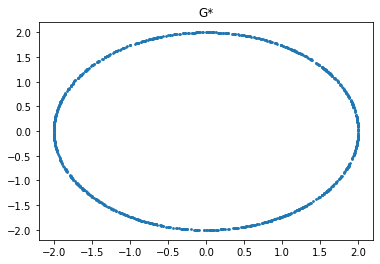

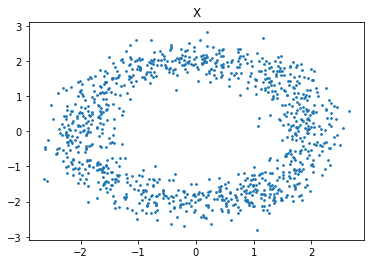

In [3]:
n=1000
x_orig, y_orig = generate_circular(n, 2)

plt.scatter(x_orig, y_orig, s=3)
plt.title('G*')
plt.show()

x = x_orig + np.random.normal(loc=0.0, scale=0.3, size=n)
y = y_orig + np.random.normal(loc=0.0, scale=0.3, size=n)

plt.scatter(x, y, s=3)
plt.title('X')
plt.show()

2022-09-30 18:25:26.400328: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 18:25:26.403686: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


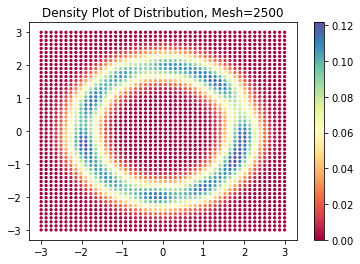

In [4]:
plot_dist(-3, 3, 50, [0.3,0.3])

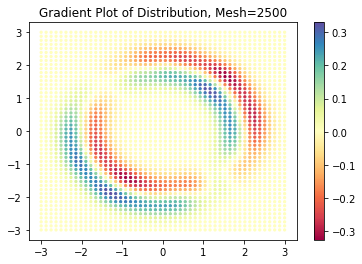

In [59]:
plot_grads(-3, 3, 50, [0.3,0.3])

In [4]:
data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))

gradients done


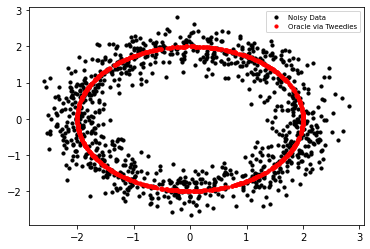

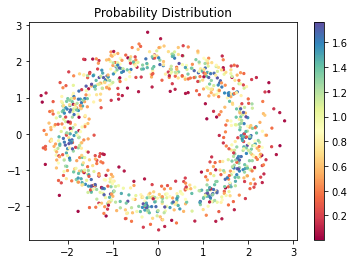

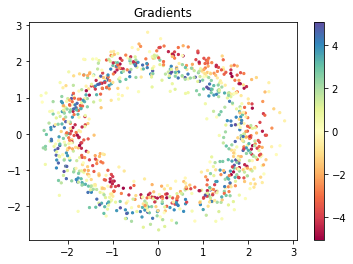

In [6]:
#ORACLE PLOT
theta_hat, gradients, probs = oracle2d(data, [0.3, 0.3], gradient_flag=True)

plt.scatter(x, y, s=10, color='black')
plt.scatter(theta_hat[:, 0], theta_hat[:, 1] , s=10, color='red')
plt.legend(['Noisy Data', 'Oracle via Tweedies'], fontsize=7)
plt.show()
plt.scatter(data[:,0],data[:,1], c=probs, s=5, cmap='Spectral')
cbar = plt.colorbar()
plt.title('Probability Distribution')
plt.show()
plt.scatter(data[:,0],data[:,1], c=np.sum(gradients, axis=1), s=5, cmap='Spectral')
cbar = plt.colorbar()
plt.title('Gradients')
plt.show()

In [5]:
#MAF
train_data, val_data = train_test_split(data, test_size=0.33, random_state=42)
train_data = tf.convert_to_tensor(train_data, dtype=np.float32)
val_data = tf.convert_to_tensor(val_data, dtype=np.float32)

batch_size = 500
train_data = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_data.batch(batch_size)

2022-10-01 21:13:33.558654: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 21:13:33.559364: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


2022-10-01 21:13:33.649823: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


0, train_loss: 7.540585994720459, val_loss: 7.847401142120361


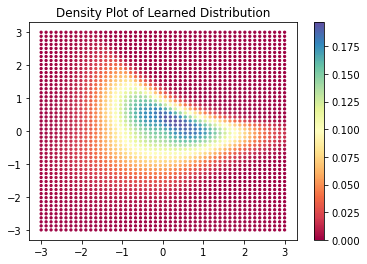

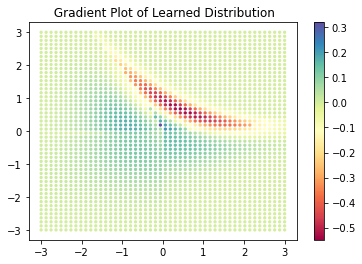

1000, train_loss: 2.9133858680725098, val_loss: 3.6706933975219727


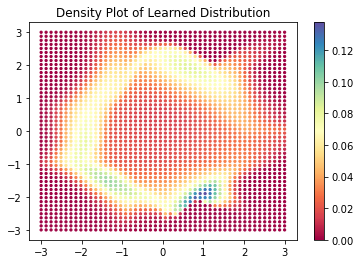

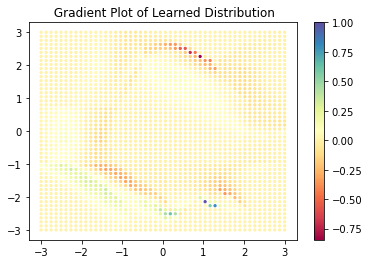

In [6]:
hidden_shape = [5, 5]  # hidden shape for MADE network of MAF
dist = maf_flow(4, hidden_shape, batched_train_data, val_data, max_epochs=10000, plot_freq=1000, delta_stop=1000)

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


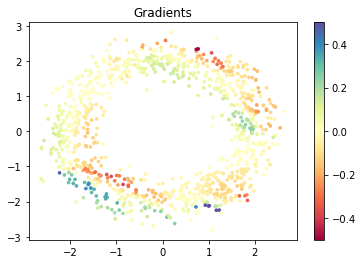

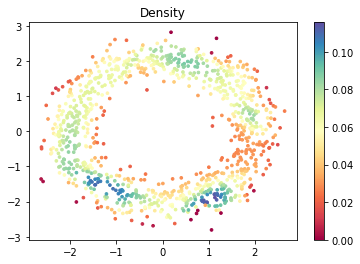

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


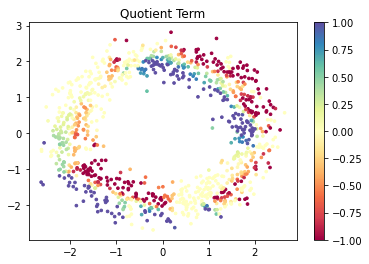

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


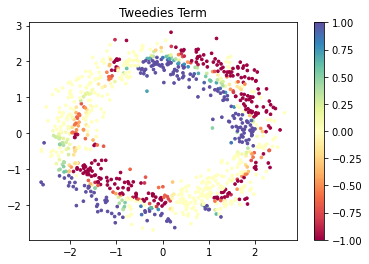

In [7]:
tf_data = tf.convert_to_tensor(data, dtype=np.float32)
theta_hat = tweedies(tf_data, dist, min_val= -0.5, max_val=0.5)

In [8]:
covariance = np.cov(tf_data.numpy().T)
with tf.GradientTape() as tape:
    tape.watch(tf_data)
    prob = dist.prob(tf_data)
    gradients = tape.gradient(prob, tf_data)

gradients = gradients.numpy()
prob = prob.numpy()
prob_div = prob.reshape((len(gradients), 1))

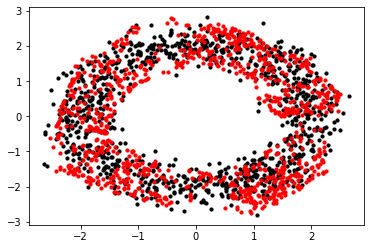

In [9]:
plt.scatter(x, y, s=10, color='black')
plt.scatter(theta_hat[:, 0], theta_hat[:, 1] , s=10, color='red')
plt.show()